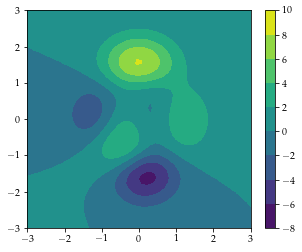

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import numpy as np
import itertools

from sumomo import API
from utils import peaks, plot_peaks, func_1d, plot_1d, plot_1d_old, plot_triangles


plot_peaks()

In [2]:
api = API(4, [(-3.0, 3.0), (-3.0, 3.0)])

api.x = np.array(list(itertools.product(*api.space)))

api.y = peaks(api.x)

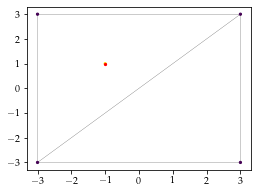

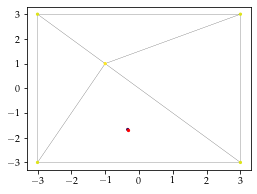

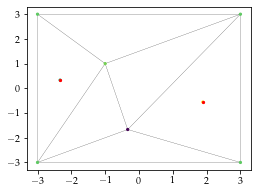

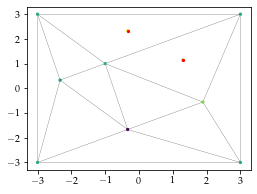

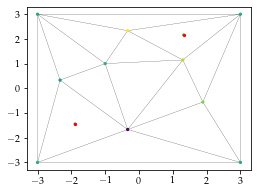

In [3]:
for i in range(5):

    explore_sample = api.delaunay_explore()
    exploit_sample = api.delaunay_exploit(sense='max')

    new = np.r_[[explore_sample], [exploit_sample]]
    new = np.unique(new, axis=0)
    
    api.x = np.r_[api.x, new]
    api.y = np.r_[api.y, peaks(new).reshape(-1, 1)]
        
    plot_triangles(api, new)

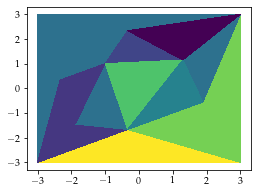

In [4]:
sizes = api._get_delaunay_centroids_and_sizes()[1]

import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
plt.tripcolor(api.delaunay.points[:, 0], api.delaunay.points[:, 1], api.delaunay.simplices, facecolors=sizes)

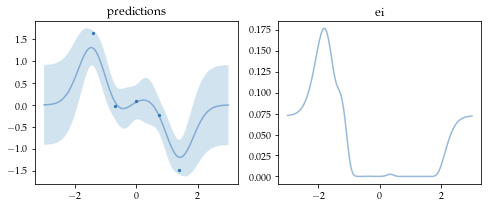

In [5]:
api = API(5, [(-3.0, 3.0)], 1, 'lhs')

for i in range(api.x.shape[0]):
    api.y[i] = func_1d(api.x[i])

api.scale()
api.init_regressor('gp', noise=0.2)

with np.errstate(divide='ignore'):
    api.regressor.fit(api.x_, api.y_)

api.new = api.max_expected_improvement(aquisition='ei')

plot_1d_old(api)

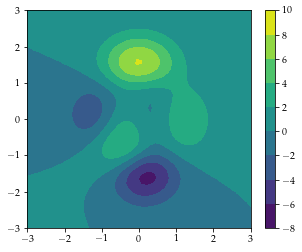

In [6]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import numpy as np
from utils import peaks, plot_peaks, feas

plot_peaks()

In [7]:
from sumomo import DataHandler


n = 100    # number of samples
space = [[-3.0, 3.0],[-3.0, 3.0]]  # input space

dh = DataHandler()  # initialise DataHandler
dh.init(n, space)   # initialise input samples, x
dh.y = peaks(dh.x)  # save output samples, y
dh.t = feas(dh.x)   # save class targets, t

dh.split(test_size=0.3)  # train-test split
dh.scale()    # standardise data

In [8]:
from sumomo import GPR, GPC

regressor = GPR()   # build GP for regression
classifier = GPC()  # build GP for classification

# fit regression GP to feasible scaled training data
regressor.fit(
    dh.x_train_[dh.t_train.ravel()==1, :], 
    dh.y_train_[dh.t_train.ravel()==1]
)

# fit classification NN to scaled training data
classifier.fit(
    dh.x_train_, 
    dh.t_train
)

/Users/alexdurkin/miniconda3/envs/sumomo-env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


In [9]:
from sklearn.metrics import ( 
    accuracy_score, 
    precision_score, 
    recall_score,
    f1_score,
    log_loss
)


prob_test, class_test = classifier.predict(dh.x_test_, return_class=True)

accuracy = accuracy_score(dh.t_test, class_test)
precision = precision_score(dh.t_test, class_test)
recall = recall_score(dh.t_test, class_test)
f1 = f1_score(dh.t_test, class_test)
bce = log_loss(dh.t_test, prob_test)

print('{:10} {:12}'.format('metric', 'value'))
print('{:10} {:<12.3f}'.format('accuracy', accuracy))
print('{:10} {:<12.3f}'.format('precision', precision))
print('{:10} {:<12.3f}'.format('recall', recall))
print('{:10} {:<12.3f}'.format('F1', f1))
print('{:10} {:<12.3f}'.format('log loss', bce))

metric     value       
accuracy   0.967       
precision  1.000       
recall     0.909       
F1         0.952       
log loss   0.182       


In [10]:
from sklearn.metrics import ( 
    mean_absolute_error, 
    mean_squared_error, 
    mean_absolute_percentage_error,
    median_absolute_error,
    explained_variance_score,
    r2_score,
    max_error
)

pred_test_ = regressor.predict(dh.x_test_)
pred_test = dh.inv_scale_y(pred_test_)

mae = mean_absolute_error(dh.y_test, pred_test)
mse = mean_squared_error(dh.y_test, pred_test)
mape = mean_absolute_percentage_error(dh.y_test, pred_test)
evs = explained_variance_score(dh.y_test, pred_test)
r2 = r2_score(dh.y_test, pred_test)
maxe = max_error(dh.y_test, pred_test)

mae_p1 = mean_absolute_error(dh.y_test[class_test == 1], pred_test[class_test == 1])
mse_p1 = mean_squared_error(dh.y_test[class_test == 1], pred_test[class_test == 1])
mape_p1 = mean_absolute_percentage_error(dh.y_test[class_test == 1], pred_test[class_test == 1])
evs_p1 = explained_variance_score(dh.y_test[class_test == 1], pred_test[class_test == 1])
r2_p1 = r2_score(dh.y_test[class_test == 1], pred_test[class_test == 1])
maxe_p1 = max_error(dh.y_test[class_test == 1], pred_test[class_test == 1])

mae_a1 = mean_absolute_error(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
mse_a1 = mean_squared_error(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
mape_a1 = mean_absolute_percentage_error(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
evs_a1 = explained_variance_score(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
r2_a1 = r2_score(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])
maxe_a1 = max_error(dh.y_test[dh.t_test == 1], pred_test[dh.t_test == 1])

print('{:8} {:12} {:12} {:12}'.format('metric', 'all testing', 'predicted 1', 'actual 1'))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('MAE', mae, mae_p1, mae_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('MSE', mse, mse_p1, mse_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('MAPE', mape, mape_p1, mape_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('EVS', evs, evs_p1, evs_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('R2', r2, r2_p1, r2_a1))
print('{:8} {:<12.3f} {:<12.3f} {:<12.3f}'.format('MAXE', maxe, maxe_p1, maxe_a1))

metric   all testing  predicted 1  actual 1    
MAE      0.396        0.191        0.184       
MSE      0.268        0.061        0.056       
MAPE     27.302       0.137        0.127       
EVS      0.957        0.992        0.995       
R2       0.934        0.992        0.994       
MAXE     1.579        0.529        0.529       


In [11]:
import pyomo.environ as pyo
from sumomo import BlockFormulation


# larger optimisation formulation
omo = pyo.ConcreteModel()
omo.n_inputs = set(range(len(space)))
omo.inputs = pyo.Var(omo.n_inputs, bounds=dh.space_)
omo.output = pyo.Var()
omo.proba = pyo.Var()
omo.feasibility_con = pyo.Constraint(expr= omo.proba >= 0.5 )
omo.obj = pyo.Objective(expr=omo.output, sense=pyo.maximize)

# formulate pyomo blocks for gpr and gpc
omo.mdl = pyo.Block(rule=BlockFormulation(regressor).rule())
omo.feas = pyo.Block(rule=BlockFormulation(classifier).rule())

# connect pyomo model input and output to the surrogate models
omo.c = pyo.ConstraintList()
for i in omo.n_inputs:
    omo.c.add( omo.inputs[i] == omo.mdl.inputs[i] )
    omo.c.add( omo.inputs[i] == omo.feas.inputs[i] )
omo.c.add( omo.output == omo.mdl.outputs[0] )
omo.c.add( omo.proba == omo.feas.outputs[0] )

In [12]:
# solver setup
solver = pyo.SolverFactory('baron')
solver.options['MaxTime'] = 30
# macOS requires CplexLibName option to be specified, please change accordingly
solver.options['CplexLibName'] = "/Applications/CPLEX_Studio201/cplex/bin/x86-64_osx/libcplex2010.dylib"
# solve
results = solver.solve(omo, tee=True)

# inverse scale solution
x = np.fromiter(omo.inputs.extract_values().values(), dtype=float).reshape(1, -1)
solution = dh.inv_scale_x(x).ravel()

# inverse scale objective and corresponding predictions
obj = dh.inv_scale_y(np.array(omo.output.value).reshape(1, -1))
pred = dh.inv_scale_y(regressor.predict(x.reshape(1, -1)))

# compare optimisation outputs with model prediction
print()
print('{:18} {:12}'.format('variable', 'value'))
print('{:18} {:<12.8f}'.format('x1*', solution[0]))
print('{:18} {:<12.8f}'.format('x2*', solution[1]))
print('{:18} {:<12.8f}'.format('omo obj at x*', obj[0][0]))
print('{:18} {:<12.8f}'.format('pred at x*', pred[0][0]))
print('{:18} {:<12.8f}'.format('omo proba', omo.proba.value))
print('{:18} {:<12.8f}'.format('proba pred at x*', classifier.predict(x.reshape(1, -1)).item()))

 BARON version 22.4.20. Built: OSX-64 Wed Apr 20 10:52:09 EDT 2022

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Benoit Chachuat at Imperial College London, b.chachuat@imperial.ac.uk.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC, ILOG CPLEX                             
 For NLP: IPOPT, FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value  1.07074449698     
 Solving bounding LP
 Starting multi-start local search
 Preprocessing found feasible solution with value  2.31977071836     
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
          1    

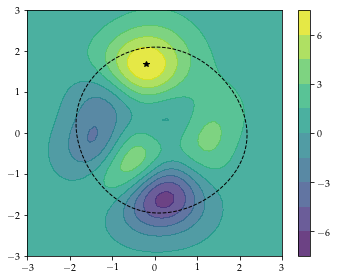

In [13]:
import matplotlib.pyplot as plt


x1, x2 = np.linspace(-3, 3, 50), np.linspace(-3, 3, 50)
x1grid, x2grid = np.meshgrid(x1, x2)
x_new = np.c_[x1grid.ravel(), x2grid.ravel()]
x_scaled = dh.scale_x(x_new)

pred = regressor.predict(x_scaled)
pred = dh.inv_scale_y(pred)
pred = pred.reshape(x1grid.shape)

prob = classifier.predict(x_scaled)
prob = prob.reshape(x1grid.shape)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
c = ax.contourf(x1, x2, pred, levels=12, alpha=0.8)
ax.contour(x1, x2, prob, levels=[0.5], linestyles='dashed', colors='k', linewidths=1)
ax.plot(solution[0], solution[1], 'k*')
fig.colorbar(c)

plt.tight_layout()

# AdaptiveSampler

* Use different `solver` configurations for heuristic solve in adaptive sampling, e.g. baron with only multi local search or other heuristic solvers.
* Constrained and unconstrained by classifier, include discussion of training regressor only on feasible samples.
* How to integrate new samples into DataHandler and continue sampling?
* Relax feasibility constraints to enable updating of classification model at boundary?
* Use `_gpr_std_rule` formulation within multi-objective optimisation.
* Termination/convergence criteria?
* Delaunay triangle adaptive sampling with feasibility constraints?

In [14]:
from sumomo import AdaptiveSampler


ads = AdaptiveSampler(dh.space_, regressor)
new = ads.max_gp_std()
new = dh.inv_scale_x(new).ravel()

ads_cons = AdaptiveSampler(dh.space_, regressor, classifier)
new_cons = ads_cons.max_gp_std(solver=solver)
new_cons = dh.inv_scale_x(new_cons).ravel()

ads_cons_dt = AdaptiveSampler(dh.space, classifier=classifier)
new_dt = ads_cons.max_dt(dh.x_train, solver=solver).ravel()
# new_dt = dh.inv_scale_x(new_dt).ravel()

print(new)
print(new_cons)
print(new_dt)

 BARON version 22.4.20. Built: OSX-64 Wed Apr 20 10:52:09 EDT 2022

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Benoit Chachuat at Imperial College London, b.chachuat@imperial.ac.uk.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC, ILOG CPLEX                             
 For NLP: IPOPT, FILTERSQP
 Doing local search
 Solving bounding LP
 Starting multi-start local search
 Preprocessing found feasible solution with value 0.997297819051     
 Preprocessing found feasible solution with value 0.651916384702     
 Preprocessing found feasible solution with value 0.587459632242     
 Preprocessing found feasible solution with 

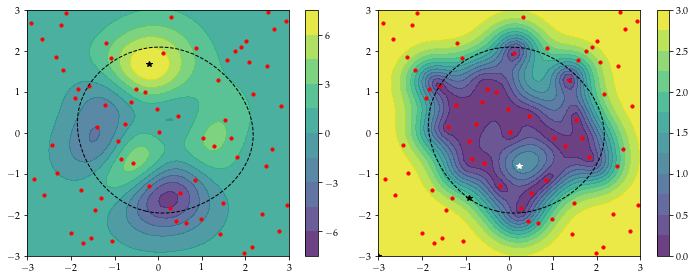

In [15]:
u = regressor.predict(x_scaled, return_std=True)[1]
u = u * dh.y_train_std
u = u.reshape(x1grid.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
c1 = ax1.contourf(x1, x2, pred, levels=12, alpha=0.8)
ax1.contour(x1, x2, prob, levels=[0.5], linestyles='dashed', colors='k', linewidths=1)
ax1.scatter(dh.x_train[:, 0], dh.x_train[:, 1], c='r', s=10)
ax1.plot(solution[0], solution[1], 'k*')
fig.colorbar(c1, ax=ax1)

c2 = ax2.contourf(x1, x2, u, levels=12, alpha=0.8)
ax2.contour(x1, x2, prob, levels=[0.5], linestyles='dashed', colors='k', linewidths=1)
ax2.scatter(dh.x_train[:, 0], dh.x_train[:, 1], c='r', s=10)
ax2.plot(new[0], new[1], 'k*')
ax2.plot(new_cons[0], new_cons[1], 'k*')
ax2.plot(new_dt[0], new_dt[1], 'w*')
fig.colorbar(c2, ax=ax2)

plt.tight_layout()